## Run & Tune XGBoost, Produce SHAP Visualization

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler


### Data Import & Slice for City, Mode, Ablation Subsets

In [ ]:
chi_df = pd.read_csv('/Users/mcott/Desktop/UMich/Milestone II/CHI_trunc.csv',dtype={1: str})
ny_df = pd.read_csv('/Users/mcott/Desktop/UMich/Milestone II/NYC_trunc.csv',dtype={1: str})

ny_df = ny_df.rename(columns={'mode_subway': 'mode_train'})

chi_bus_df =  chi_df[(chi_df['mode_train'] == False)]
chi_train_df = chi_df[(chi_df['mode_train'] == True)]
ny_bus_df = ny_df[(ny_df['mode_train'] == False)]
ny_train_df = ny_df[(ny_df['mode_train'] == True)]

concat_df = pd.concat([chi_df,ny_df], ignore_index=True)
comb_df = concat_df.groupby('date', as_index=False).agg('first')  
comb_df['daily_ridership'] = concat_df.groupby('date')['daily_ridership'].sum().values
comb_df = comb_df.drop(columns=['mode'])


In [136]:
reduced_cols = ['is_weekend',
 'is_holiday',
 'is_holiday_adjacent', 
 'us_aqi_mean',
 'us_aqi_pm2_5_mean',
 'us_aqi_pm10_mean',
 'us_aqi_nitrogen_dioxide_mean',
 'us_aqi_ozone_mean',
 'us_aqi_sulphur_dioxide_mean',
 'us_aqi_carbon_monoxide_mean',
 'apparent_temperature_max',
 'apparent_temperature_min',
 'apparent_temperature_max_lag',
 'apparent_temperature_min_lag',
 'relative_humidity_2m_mean',
 'rain_sum',
 'rain_max',
 'snow_any',
 'snow_heavy',
 'wind_speed_10m_mean',
 'wind_speed_10m_max',
 'wind_direction_10m_mean',
 'date',
 'mode_train',
 'daily_ridership']

reduced_chi_df = chi_df[reduced_cols]
reduced_chi_bus_df = reduced_chi_df[reduced_chi_df['mode_train'] == False]
reduced_chi_train_df = reduced_chi_df[reduced_chi_df['mode_train'] == True]

reduced_ny_df = ny_df[reduced_cols]
reduced_ny_bus_df = reduced_ny_df[reduced_ny_df['mode_train'] == False]
reduced_ny_train_df = reduced_ny_df[reduced_ny_df['mode_train'] == True]

reduced_comb_df = comb_df[reduced_cols]

In [173]:
ablation_cols = ['us_aqi_mean',
 'us_aqi_pm2_5_mean',
 'us_aqi_pm10_mean',
 'us_aqi_nitrogen_dioxide_mean',
 'us_aqi_ozone_mean',
 'us_aqi_sulphur_dioxide_mean',
 'us_aqi_carbon_monoxide_mean',
 'apparent_temperature_max',
 'apparent_temperature_min',
 'apparent_temperature_max_lag',
 'apparent_temperature_min_lag',
 'relative_humidity_2m_mean',
 'rain_sum',
 'rain_max',
 'snow_any',
 'snow_heavy',
 'wind_speed_10m_mean',
 'wind_speed_10m_max',
 'wind_direction_10m_mean',
 'date',
 'mode_train',
 'daily_ridership']

ablation_df = comb_df[ablation_cols]

abl_cb_df = chi_bus_df[ablation_cols]
abl_ct_df = chi_train_df[ablation_cols]
abl_nb_df = ny_bus_df[ablation_cols]
abl_nt_df = ny_train_df[ablation_cols]

In [170]:
aqi_only_cols = ['us_aqi_pm2_5_min',
'us_aqi_pm2_5_max',
'us_aqi_pm2_5_mean',
'us_aqi_min',
'us_aqi_max',
'us_aqi_mean',
'us_aqi_pm10_min',
'us_aqi_pm10_max',
'us_aqi_pm10_mean',
'us_aqi_nitrogen_dioxide_min',
'us_aqi_nitrogen_dioxide_max',
'us_aqi_nitrogen_dioxide_mean',
'us_aqi_carbon_monoxide_min',
'us_aqi_carbon_monoxide_max',
'us_aqi_carbon_monoxide_mean',
'us_aqi_ozone_min',
'us_aqi_ozone_max',
'us_aqi_ozone_mean',
'us_aqi_sulphur_dioxide_min',
'us_aqi_sulphur_dioxide_max',
'us_aqi_sulphur_dioxide_mean',
'us_aqi_min_bin',
'us_aqi_min_bin_lag',
'us_aqi_min_lag',
'us_aqi_max_bin',
'us_aqi_max_bin_lag',
'us_aqi_max_lag',
'us_aqi_mean_bin',
'us_aqi_mean_bin_lag',
'us_aqi_mean_lag',
 'date',
 'mode_train',
 'daily_ridership']


aqi_only_df = comb_df[aqi_only_cols]

### XGboost Testing & Results

In [ ]:
def XGBoost(df):
    
    # Prepare data
    target_col = 'daily_ridership'
    X = df.drop(columns=[target_col,'date','mode_train'])
    y = df[target_col]

    test_size = int(len(X) * 0.2)
    X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
    y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

    # Search for best parameters
    xgb = XGBRegressor(random_state=27, n_jobs=-1, tree_method='hist', verbosity=0)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [2, 5, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_child_weight': [3, 5, 10],
        #'subsample': [0.8, 0.9, 1.0], - impact of <1 on MAE
        #'colsample_bytree': [0.8, 0.9, 1.0], - impact of <1 on MAE
        #'reg_alpha': [0, 0.5, 1], # - 0 always selected in testing
        'reg_lambda': [1, 5, 10]
    }

    grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    xgb = grid_search.best_estimator_
    print("Best Parameters:", grid_search.best_params_)

    # Cross-val scoring
    tscv = TimeSeriesSplit(n_splits=5)
    r2_scores = []
    rmse_scores = []

    for inner_train_idx, inner_val_idx in tscv.split(X_train, y_train):
        X_inner_train, X_inner_val = X_train.iloc[inner_train_idx], X_train.iloc[inner_val_idx]
        y_inner_train, y_inner_val = y_train.iloc[inner_train_idx], y_train.iloc[inner_val_idx]

        xgb.fit(X_inner_train, y_inner_train)
        y_val_pred = xgb.predict(X_inner_val)

        r2_scores.append(r2_score(y_inner_val, y_val_pred))
        rmse_scores.append(root_mean_squared_error(y_inner_val, y_val_pred))

    print("R² scores (CV):", r2_scores)
    print("RMSE scores (CV):", rmse_scores)
    print(f"Mean R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    print(f"Mean RMSE: {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}")

    importances = xgb.feature_importances_
    feat_names = X_train.columns
    sorted_idx = np.argsort(importances)[::-1]
    plt.barh(range(10), importances[sorted_idx[:10]])
    plt.yticks(range(10), feat_names[sorted_idx[:10]])
    plt.xlabel("Feature Importance")
    plt.title("Top 10 Important Features",loc = 'center')
    plt.gca().invert_yaxis()
    plt.show()

    xgb.fit(X_train, y_train)
    y_pred_test = xgb.predict(X_test)
    print(f"Test R²: {r2_score(y_test, y_pred_test):.4f}")
    print(f"Test RMSE: {root_mean_squared_error(y_test, y_pred_test):.2f}")
    print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
    
    return xgb #, X_train, X_test, y_train, y_test

Best Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 100, 'reg_lambda': 1}
R² scores (CV): [0.31693740591709063, -0.19172815625188977, 0.3645851264294324, -0.03963670629978444, -0.763609058734251]
RMSE scores (CV): [402.6081841659189, 561.606743772601, 597.7009226603795, 554.1493580431616, 516.6779451486004]
Mean R²: -0.0627 ± 0.4087
Mean RMSE: 526.55 ± 67.10


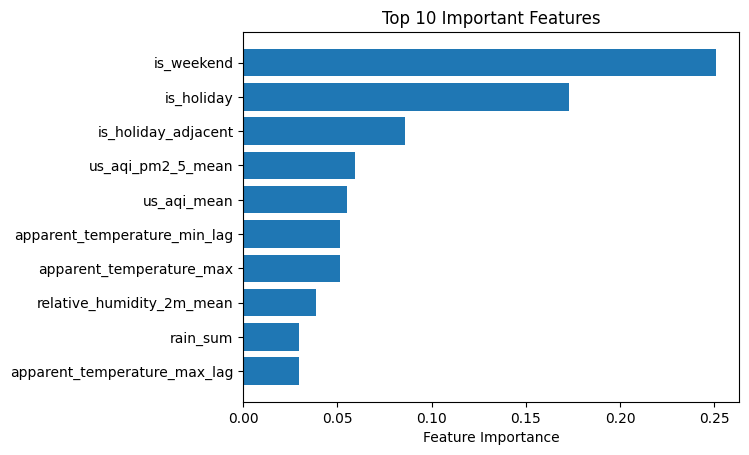

Test R²: 0.2521
Test RMSE: 634.64
Test MAE: 556.90


In [140]:
cb_xgb = XGBoost(reduced_chi_bus_df)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 100, 'reg_lambda': 1}
R² scores (CV): [0.44663679224453967, 0.21034433281336629, 0.6201390754201583, 0.6519246369208876, 0.5865083441756538]
RMSE scores (CV): [317.2030399823987, 361.4382024330269, 341.24157786605684, 282.09724345818836, 268.8095079011654]
Mean R²: 0.5031 ± 0.1623
Mean RMSE: 314.16 ± 34.82


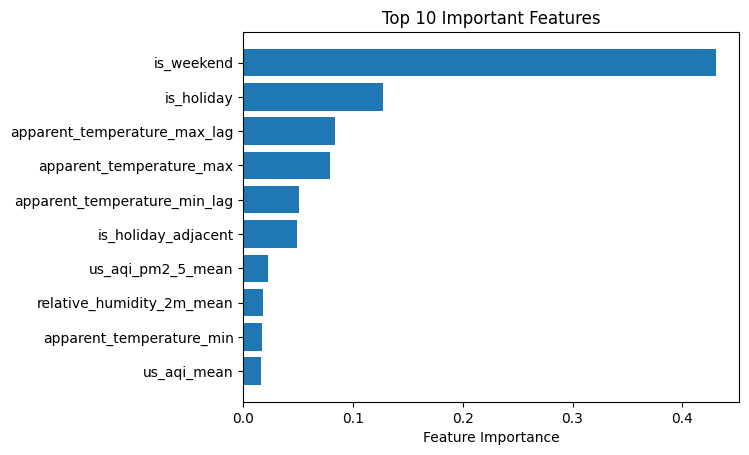

Test R²: 0.6121
Test RMSE: 325.55
Test MAE: 259.44


In [141]:
ct_xgb = XGBoost(reduced_chi_train_df)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 300, 'reg_lambda': 10}
R² scores (CV): [0.7930842175344063, 0.8582804222461904, 0.647207747475248, 0.7429554746696776, 0.8009153146969761]
RMSE scores (CV): [345.1765465615958, 260.6692664467983, 439.45004369549866, 335.85318729934806, 278.583837158835]
Mean R²: 0.7685 ± 0.0708
Mean RMSE: 331.95 ± 62.73


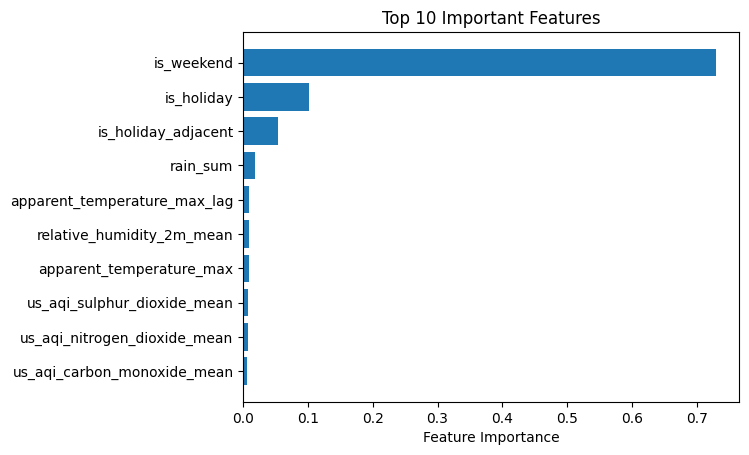

Test R²: 0.7807
Test RMSE: 354.04
Test MAE: 298.59


In [142]:
nb_xgb = XGBoost(reduced_ny_bus_df)

Best Parameters: {'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 200, 'reg_lambda': 1}
R² scores (CV): [0.7774943998392516, 0.8188930661538592, 0.791339660808583, 0.8340305367172031, 0.8398047837706124]
RMSE scores (CV): [846.6505600759011, 741.0844845210964, 902.85075948194, 751.3588143688105, 714.9251701387332]
Mean R²: 0.8123 ± 0.0242
Mean RMSE: 791.37 ± 71.35


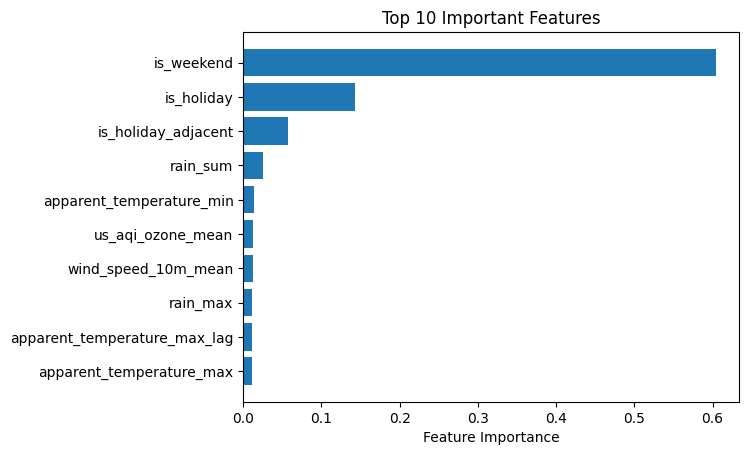

Test R²: 0.6894
Test RMSE: 1100.04
Test MAE: 924.11


In [166]:
nt_xgb = XGBoost(reduced_ny_train_df)

Best Parameters: {'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 100, 'reg_lambda': 1}
R² scores (CV): [0.7400593081237413, 0.7239916874847425, 0.6961687702873027, 0.8395360237376386, 0.806695496182668]
RMSE scores (CV): [1713.3254986671002, 1691.1030623122203, 2151.1985502332845, 1361.3175257937085, 1356.314520698251]
Mean R²: 0.7613 ± 0.0534
Mean RMSE: 1654.65 ± 292.02


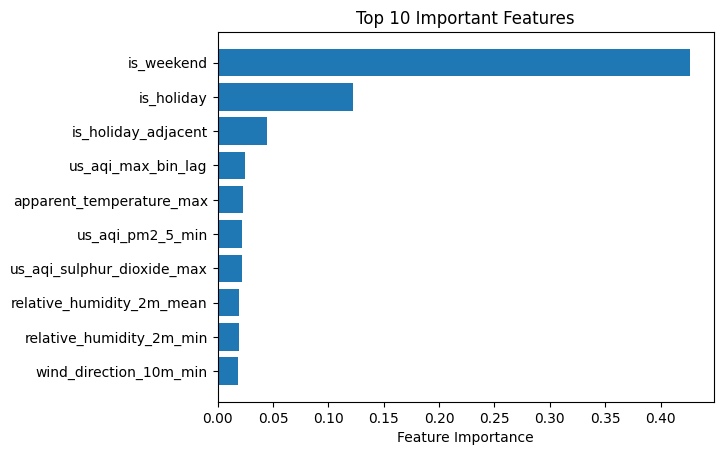

Test R²: 0.6561
Test RMSE: 2232.41
Test MAE: 1953.96


In [167]:
all_xgb = XGBoost(comb_df)

Best Parameters: {'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 100, 'reg_lambda': 5}
R² scores (CV): [0.7739030047513071, 0.7395511309168912, 0.7249881212005413, 0.8434938828216807, 0.7986728638356022]
RMSE scores (CV): [1597.9019930741422, 1642.7452989302049, 2046.633211755065, 1344.4241940304978, 1384.1736671014287]
Mean R²: 0.7761 ± 0.0424
Mean RMSE: 1603.18 ± 250.26


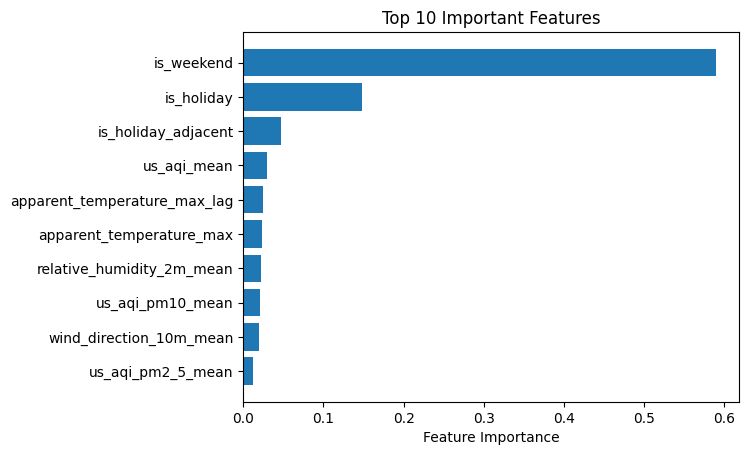

Test R²: 0.6492
Test RMSE: 2254.44
Test MAE: 1969.89


In [145]:
all_xgb_reduced = XGBoost(reduced_comb_df)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 200, 'reg_lambda': 10}
R² scores (CV): [-0.11113483450851391, -0.19836089844203442, -0.03511019280371119, -0.041418893091739406, 0.006024400704306432]
RMSE scores (CV): [3542.3064068322756, 3523.731509794942, 3970.6132125870618, 3468.034322698285, 3075.5818302156167]
Mean R²: -0.0760 ± 0.0718
Mean RMSE: 3516.05 ± 284.15


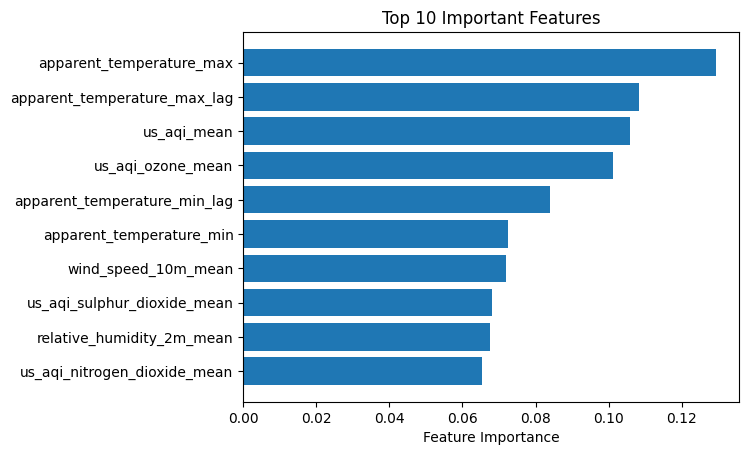

Test R²: -0.0539
Test RMSE: 3907.88
Test MAE: 3505.42


In [146]:
abla_xgb = XGBoost(ablation_df)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 300, 'reg_lambda': 10}
R² scores (CV): [-0.12511902803232577, -0.6054823781781618, -0.01827943626933215, -0.7007749448037088, -0.8429481908097367]
RMSE scores (CV): [516.7156103983007, 651.8482224483048, 756.6390036083035, 708.7767399655204, 528.1719419412449]
Mean R²: -0.4585 ± 0.3265
Mean RMSE: 632.43 ± 95.81


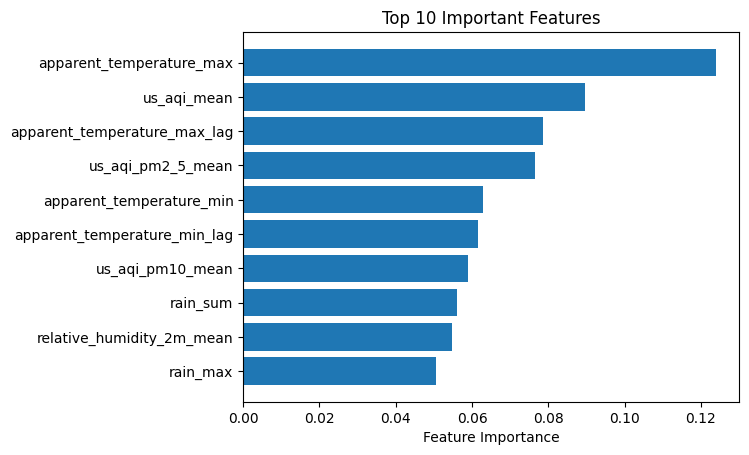

Test R²: -0.1003
Test RMSE: 769.77
Test MAE: 668.62


In [174]:
abla_xgb_cb = XGBoost(abl_cb_df)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 300, 'reg_lambda': 10}
R² scores (CV): [-0.26839284748867587, -0.5556661634734192, -0.009302944167456362, -0.06439000548441798, -0.061949654217765326]
RMSE scores (CV): [480.2408432180627, 507.30994755868886, 556.2376748695278, 493.30167938751174, 430.7876207140082]
Mean R²: -0.1919 ± 0.2023
Mean RMSE: 493.58 ± 40.58


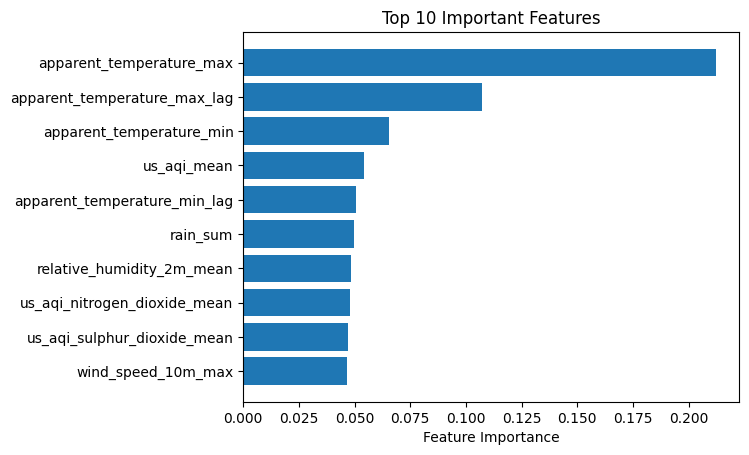

Test R²: 0.1122
Test RMSE: 492.55
Test MAE: 433.18


In [175]:
abla_xgb_ct = XGBoost(abl_ct_df)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 100, 'reg_lambda': 5}
R² scores (CV): [-0.05401448884682569, -0.0909024121511528, -0.09259059123229108, -0.1072910515915717, -0.07466733276572857]
RMSE scores (CV): [779.0543573710775, 723.2157174280181, 773.354684410993, 697.0696754250476, 647.2529124181965]
Mean R²: -0.0839 ± 0.0182
Mean RMSE: 723.99 ± 49.16


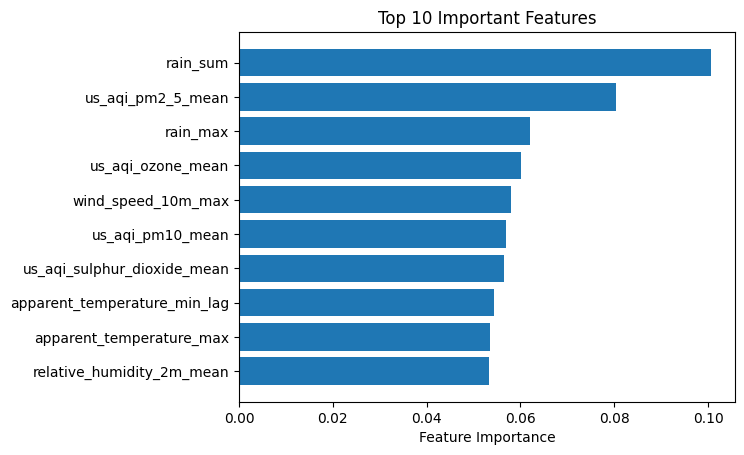

Test R²: -0.0124
Test RMSE: 760.70
Test MAE: 676.43


In [176]:
abla_xgb_nb = XGBoost(abl_nb_df)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 100, 'reg_lambda': 1}
R² scores (CV): [-0.04023637048101958, -0.15912424299399408, -0.04361761359773464, -0.03871637763824376, 0.04464830778605555]
RMSE scores (CV): [1830.6264966893752, 1874.8441692940396, 2019.1413060203515, 1879.6707375772735, 1745.8923197969627]
Mean R²: -0.0474 ± 0.0650
Mean RMSE: 1870.04 ± 88.67


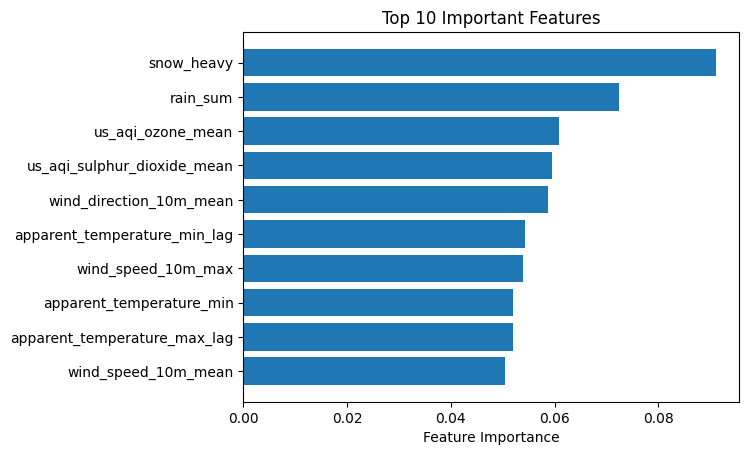

Test R²: -0.0689
Test RMSE: 2040.61
Test MAE: 1814.32


In [177]:
abla_xgb_nt = XGBoost(abl_nt_df)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 100, 'reg_lambda': 10}
R² scores (CV): [-0.08132304538160273, -0.1659333825720941, 0.01994815637980618, -0.05771623229103673, -0.028661695700274326]
RMSE scores (CV): [3494.463209646912, 3475.728648524943, 3863.5702726549275, 3495.0649075269835, 3128.7849151557734]
Mean R²: -0.0627 ± 0.0617
Mean RMSE: 3491.52 ± 232.49


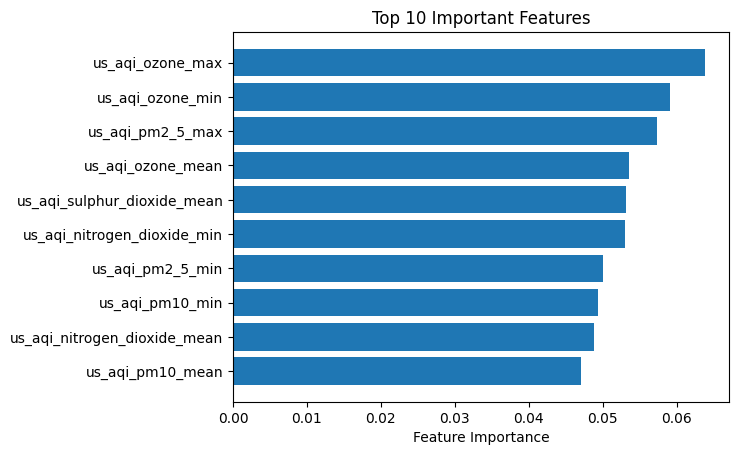

Test R²: -0.1216
Test RMSE: 4031.42
Test MAE: 3615.50


In [171]:
aqi_xgb = XGBoost(aqi_only_df)

### XGboost Visualizations - Input Top Hyperparameters

In [161]:
def XGBoost_SHAP_waterfall(df,i=0):
    
    # Prepare data
    target_col = 'daily_ridership'
    X = df.drop(columns=[target_col,'date','mode_train'])
    y = df[target_col]
    
    # Split data
    test_size = int(len(X) * 0.2)
    X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
    y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]
    
    # Train XGBoost model
    model = XGBRegressor(
        n_estimators = 150,
        max_depth = 20,
        learning_rate = 0.1,
        subsample = 0.9,
        colsample_bytree = 0.9,
        reg_alpha = 0.1,
        reg_lambda = 1,
        random_state = 27,
        n_jobs = -1,
        tree_method='hist',
        eval_metric='rmse')
    model.fit(X_train, y_train)

    # Get predictions - use for waterfalls of largest errors
    y_pred_test = model.predict(X_test)
    errors = np.abs(y_test.values - y_pred_test)

    # adjust the row index on this to evaluate additional waterfall plots 
    worst_errors = np.argsort(errors)[::-1]
    worst_index = worst_errors[i]

    df_test = df.iloc[-test_size:].reset_index(drop=True)
    original_row = df_test.iloc[worst_index]

    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # SHAP values
    explainer = shap.Explainer(model, X_train, seed=27)
    shap_values = explainer(X_test)

    # SHAP Waterfall plot example (only shows feature importance for the i-th worst prediction)
    plt.figure(figsize=(10, 8))
    shap.plots.waterfall(shap_values[worst_index],show=False)
    plt.title(
                 f"Date: {original_row['date']}\n" +
                 f"Actual: {y_test.iloc[worst_index]:.0f} | Predicted: {y_pred_test[worst_index]:.0f} | Error: {errors[worst_index]:.0f}")
    plt.tight_layout()
    plt.show()
    

    # SHAP force plot example (only shows feature importance for a single prediction)
    '''
    plt.figure(figsize=(10, 8))
    shap.force_plot(explainer.expected_value,shap_values[worst_index].values, X_test.iloc[worst_index, :], matplotlib=True)
    plt.show()
    '''

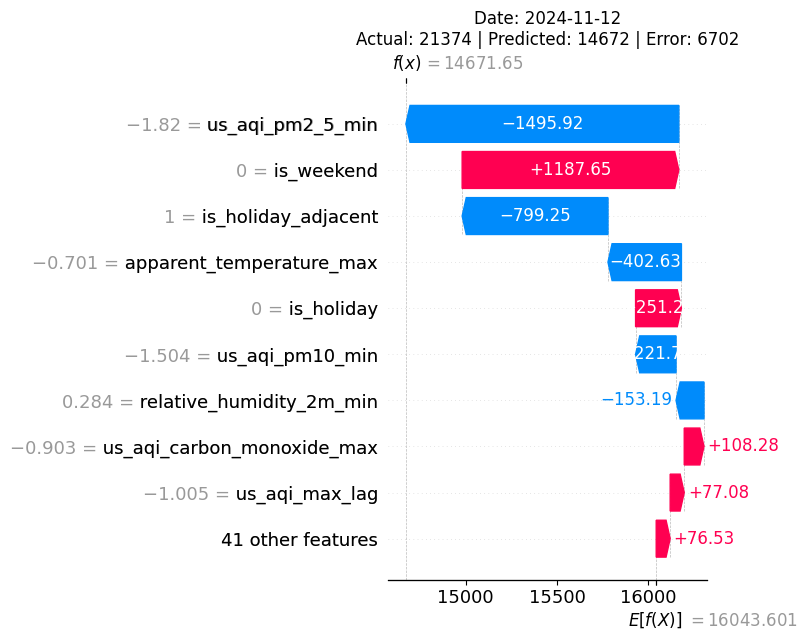

In [162]:
XGBoost_SHAP(comb_df,0)

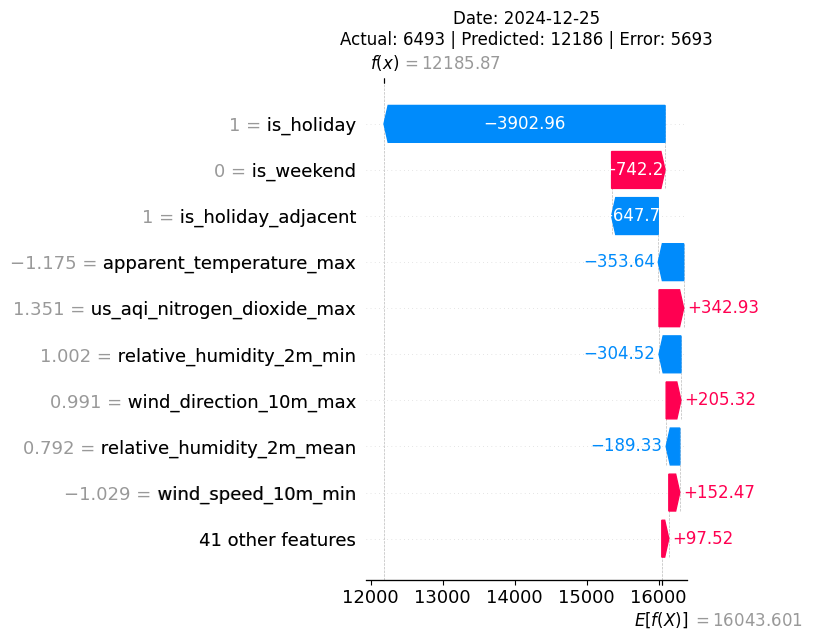

In [ ]:
XGBoost_SHAP(comb_df,1)

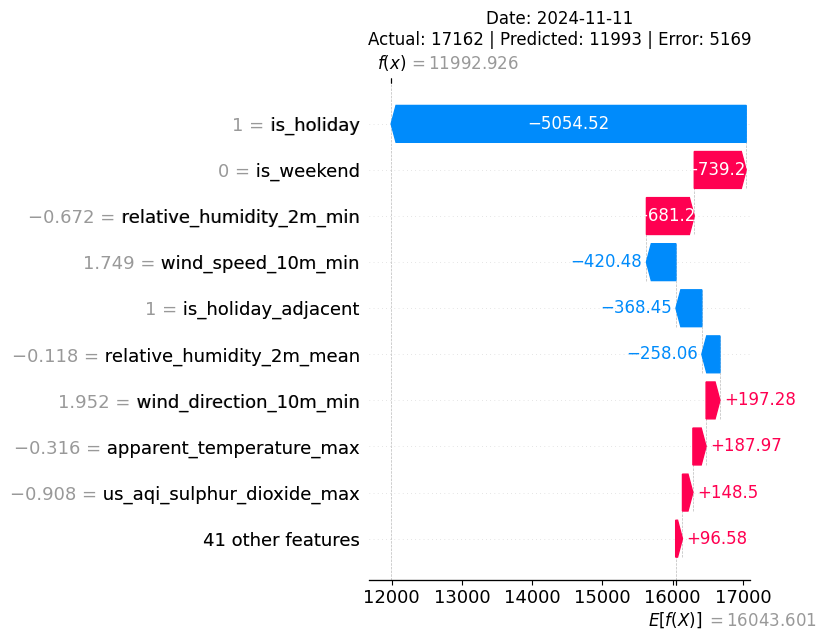

In [ ]:
XGBoost_SHAP(comb_df,2)

In [151]:
def XGBoost_SHAP_beeswarm(df):
    
    # Prepare data
    target_col = 'daily_ridership'
    X = df.drop(columns=[target_col,'date','mode_train'])
    y = df[target_col]
    
    # Split data
    test_size = int(len(X) * 0.2)
    X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
    y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]
    
    # Train XGBoost model
    model = XGBRegressor(
        n_estimators = 150,
        max_depth = 20,
        learning_rate = 0.1,
        subsample = 0.9,
        colsample_bytree = 0.9,
        reg_alpha = 0.1,
        reg_lambda = 1,
        random_state = 27,
        n_jobs = -1,
        tree_method='hist',
        eval_metric='rmse')
    model.fit(X_train, y_train)

    # SHAP values
    explainer = shap.Explainer(model, X_train, seed=27)
    shap_values = explainer(X_test)

    # Create SHAP Beeswarm plot (similar to summary plot, better performance with large datasets)

    plt.figure(figsize=(10, 8))
    shap.plots.beeswarm(shap_values, show=False)
    plt.title('SHAP Beeswarm Plot - Feature Importance')
    plt.tight_layout()
    plt.show()

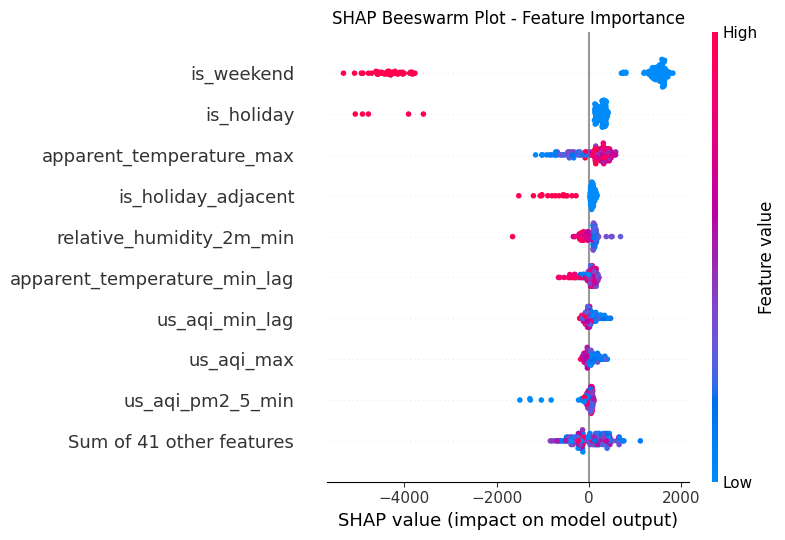

In [ ]:
XGBoost_SHAP_beeswarm(comb_df)

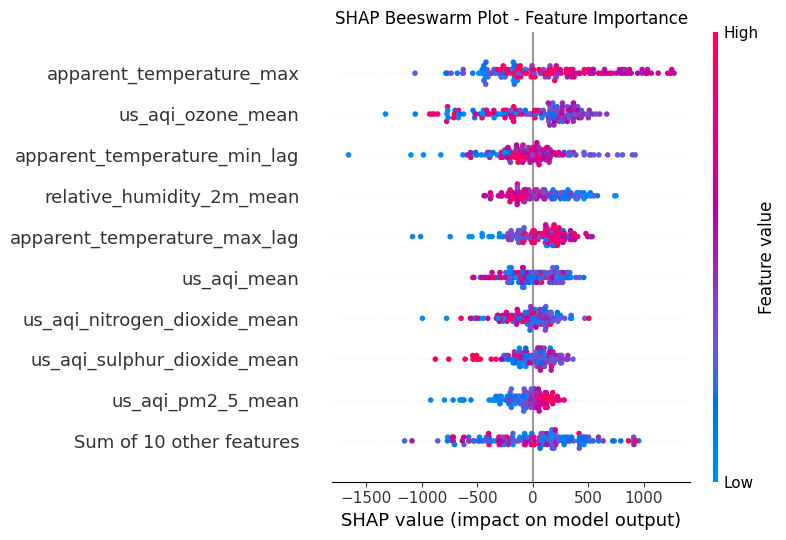

In [168]:
XGBoost_SHAP_beeswarm(ablation_df)

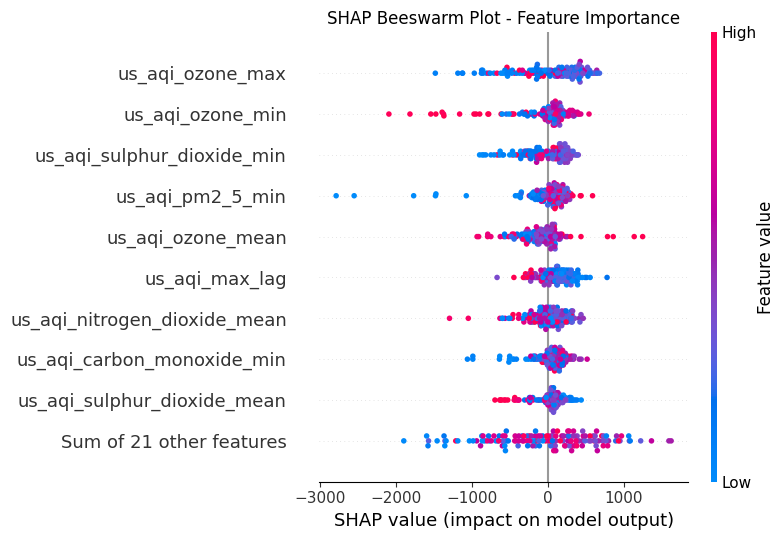

In [172]:
XGBoost_SHAP_beeswarm(aqi_only_df)